# Random Forrest
This will load the csv testing and training files into Dataframes

Your Directory should be set up like this:
```
.
│
├── Notebook_Files
│   ├── Data Normalization.ipynb
│   ├── Master Template.ipynb
│   └── Random Forrest.ipynb
├── Source
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
└── tmdb-box-office-prediction.zip

```

`train_df` - Holds training data

`test_df` - Holds testing data

`orig_df` - Original training data

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import metrics


train_df = pd.read_csv('../Source/train.csv')
test_df = pd.read_csv("../Source/test.csv")
orig_df = pd.read_csv('../Source/train.csv')


## normalize(df) function
This function needs to be ran on both testing and training data
It takes in a Pandas DataFrame and returns a DataFrame
```
How to use:
df = normalize(df)
```

In [2]:
def encode_list(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    for i in data:
        genre.append(i.get(json_tag))
    return genre

def encode_list_to_count(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    count = 0
    for i in data:
        count += 1
    return count


def normalize(df):
    
    mlb = MultiLabelBinarizer()
    
    ## Count spoken languages 
    df['language_count'] = df['spoken_languages'].apply(lambda x: encode_list_to_count(x, 'iso_639_1'))
    df.pop('spoken_languages')
    
    ## Count Producion COuntry
    df['prod_country_encoded'] = df['production_countries'].apply(lambda x: encode_list(x, 'name'))
    df['produced_in_usa'] = df['prod_country_encoded'].apply(lambda x: 1 if 'United States of America' in x else 0)
    df['prod_country_counted'] = df['production_countries'].apply(lambda x: encode_list_to_count(x, 'name'))
    df.pop('production_countries')
    df.pop('prod_country_encoded')
    
    ## Encode Genre
    df['genre_encoded'] = df['genres'].apply(lambda x: encode_list(x, 'name'))
    df_encoded = pd.DataFrame(mlb.fit_transform(df['genre_encoded']),columns=mlb.classes_, index=df.index)
    df = pd.concat([df,df_encoded], axis=1)
    df.pop('genres')
    df.pop('genre_encoded')
    
    ## Run Time
    df['runtime'] = df['runtime'].replace(np.nan, 0)
    
    ## Crew Count
    df['count_of_crew'] = df['crew'].apply(lambda x: encode_list_to_count(x,'cred_id' ))
    df. pop('crew')

    ## Cast Count
    df['count_of_cast'] = df['cast'].apply(lambda x: encode_list_to_count(x,'cast_id' ))
    df. pop('cast')
    
    ## Production Companies Count
    df['production_companies_count'] = df['production_companies'].apply(lambda x: encode_list_to_count(x,'name' ))
    df. pop('production_companies')
    
    
    ## ENCODE IF ORIGINAL LANGUAGE WAS ENGLISH
    df['orig_lang_is_eng'] = df['original_language'].apply(lambda x: 1 if 'en' in x else 0)
    df.pop('original_language')
    
    ## Cast date to a date type and correct outliers
    current_year = pd.Timestamp(year=2023, month=1, day=1, hour=0, minute=0, second=0)
    df['date'] = pd.to_datetime(df['release_date'])
    df['date'] = df['date'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_year else x)
    df.pop('release_date')
    
    ## Create release month int value
    df['release_month'] = df["date"].dt.month
    df.pop('date')  ## You can remove this if you want to used the date somehow
    
    ## Encode Collection status 
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: encode_list_to_count(x, 'name'))
    
    # drop irrelevant/unused columns
    df.pop('tagline')
    df.pop('Keywords')
    df.pop('overview')
    df.pop('id')
    df.pop('belongs_to_collection')
    df.pop('homepage')
    df.pop('imdb_id')
    df.pop('original_title')
    df.pop('poster_path')
    df.pop('title')
    df.pop('status')
    
    return df

### Normalize Train and Test data

In [3]:
train_df = normalize(train_df)
test_df = normalize(test_df)

### Adding average to budget values of 0

In [4]:
# var holding total budget
total_budget = 0
count = 0

# for loop traversing budget
for entry in train_df['budget']:
    total_budget += entry
    if entry != 0:
        count += 1
    
# finding average and adding it to entries with 0 value
budget_avg = total_budget / count
train_df.loc[train_df['budget'] == 0, 'budget'] = budget_avg
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,...,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,1.400000e+07,6.575393,93.0,12314651,1,1,1,0,0,0,...,0,0,0,0,0,72,24,3,1,2
1,4.000000e+07,8.248895,113.0,95149435,1,1,1,0,0,0,...,0,0,0,0,0,9,20,1,1,8
2,3.300000e+06,64.299990,105.0,13092000,1,1,1,0,0,0,...,0,0,0,0,0,64,51,3,1,10
3,1.200000e+06,3.174936,122.0,16000000,2,0,1,0,0,0,...,0,0,1,0,0,3,7,0,0,3
4,3.089305e+07,1.148070,118.0,3923970,1,0,1,1,0,0,...,0,0,1,0,0,2,4,0,0,2


In [5]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# split data
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

# scale feature data
X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check size of sets
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2400, 31)
(600, 31)
(2400,)
(600,)


## Find best parameters using Grid Search

In [7]:
# import tools
from sklearn.model_selection import GridSearchCV
# dictionary with parameters to test
params = {    'max_depth': [5, 6, 7, 8],
              'criterion': ['squared_error','friedman_mse'],
              'min_weight_fraction_leaf': [0,0.01, 0.001, 0.0001, 0.1],
              'min_samples_split': [2,3,4,5,6] }

# create regressor
regressor = RandomForestRegressor(random_state=2)
# create grid
xgb_grid = GridSearchCV(regressor,
                        params,
                        cv = 10,
                        scoring='r2',
                        verbose=10)

# fit the grid
xgb_grid.fit(X_train, y_train)

# see results
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[CV 1/10; 1/200] START criterion=squared_error, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0
[CV 1/10; 1/200] END criterion=squared_error, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.486 total time=   0.0s
[CV 2/10; 1/200] START criterion=squared_error, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0
[CV 2/10; 1/200] END criterion=squared_error, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.654 total time=   0.0s
[CV 3/10; 1/200] START criterion=squared_error, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0
[CV 3/10; 1/200] END criterion=squared_error, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.697 total time=   0.0s
[CV 4/10; 1/200] START criterion=squared_error, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0
[CV 4/10; 1/200] END criterion=squared_error, max_depth=5, min_samples_split=2,

/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.552 total time=   0.3s
[CV 2/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.647 total time=   0.3s
[CV 3/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.681 total time=   0.3s
[CV 4/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.738 total time=   0.3s
[CV 5/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.728 total time=   0.3s
[CV 6/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.689 total time=   0.3s
[CV 7/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.620 total time=   0.3s
[CV 8/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.642 total time=   0.3s
[CV 9/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.471 total time=   0.3s
[CV 10/10; 101/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 101/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.787 total time=   0.3s
[CV 1/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.506 total time=   0.3s
[CV 2/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.603 total time=   0.3s
[CV 3/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.3s
[CV 4/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.678 total time=   0.3s
[CV 5/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.575 total time=   0.3s
[CV 6/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.623 total time=   0.3s
[CV 7/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.661 total time=   0.3s
[CV 8/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.647 total time=   0.3s
[CV 9/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.497 total time=   0.3s
[CV 10/10; 102/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 102/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.760 total time=   0.3s
[CV 1/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.549 total time=   0.3s
[CV 2/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.650 total time=   0.3s
[CV 3/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.680 total time=   0.3s
[CV 4/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.731 total time=   0.3s
[CV 5/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.717 total time=   0.3s
[CV 6/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.689 total time=   0.3s
[CV 7/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.629 total time=   0.3s
[CV 8/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.637 total time=   0.3s
[CV 9/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.475 total time=   0.3s
[CV 10/10; 103/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 103/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.779 total time=   0.3s
[CV 1/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.552 total time=   0.3s
[CV 2/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.647 total time=   0.3s
[CV 3/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.681 total time=   0.3s
[CV 4/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.738 total time=   0.3s
[CV 5/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.728 total time=   0.3s
[CV 6/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.689 total time=   0.3s
[CV 7/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.620 total time=   0.3s
[CV 8/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.642 total time=   0.3s
[CV 9/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.471 total time=   0.3s
[CV 10/10; 104/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 104/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.787 total time=   0.3s
[CV 1/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.364 total time=   0.3s
[CV 2/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.393 total time=   0.3s
[CV 6/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.404 total time=   0.3s
[CV 7/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.451 total time=   0.3s
[CV 9/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.487 total time=   0.3s
[CV 10/10; 105/200] START criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 105/200] END criterion=friedman_mse, max_depth=5, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.553 total time=   0.3s
[CV 2/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.648 total time=   0.3s
[CV 3/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.679 total time=   0.3s
[CV 4/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.737 total time=   0.3s
[CV 5/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.728 total time=   0.3s
[CV 6/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.687 total time=   0.3s
[CV 7/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.617 total time=   0.3s
[CV 8/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.639 total time=   0.3s
[CV 9/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.477 total time=   0.3s
[CV 10/10; 106/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 106/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.784 total time=   0.3s
[CV 1/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.506 total time=   0.3s
[CV 2/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.603 total time=   0.3s
[CV 3/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.3s
[CV 4/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.678 total time=   0.3s
[CV 5/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.575 total time=   0.3s
[CV 6/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.623 total time=   0.3s
[CV 7/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.661 total time=   0.3s
[CV 8/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.647 total time=   0.3s
[CV 9/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.497 total time=   0.3s
[CV 10/10; 107/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 107/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.760 total time=   0.3s
[CV 1/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.548 total time=   0.3s
[CV 2/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.650 total time=   0.3s
[CV 3/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.681 total time=   0.3s
[CV 4/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.731 total time=   0.3s
[CV 5/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.718 total time=   0.3s
[CV 6/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.688 total time=   0.3s
[CV 7/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.629 total time=   0.3s
[CV 8/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.637 total time=   0.3s
[CV 9/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.476 total time=   0.3s
[CV 10/10; 108/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 108/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.777 total time=   0.3s
[CV 1/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.553 total time=   0.3s
[CV 2/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.648 total time=   0.3s
[CV 3/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.679 total time=   0.3s
[CV 4/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.737 total time=   0.3s
[CV 5/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.728 total time=   0.3s
[CV 6/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.687 total time=   0.3s
[CV 7/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.617 total time=   0.3s
[CV 8/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.639 total time=   0.3s
[CV 9/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.477 total time=   0.3s
[CV 10/10; 109/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 109/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.784 total time=   0.3s
[CV 1/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.364 total time=   0.3s
[CV 2/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.393 total time=   0.3s
[CV 6/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.404 total time=   0.3s
[CV 7/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.451 total time=   0.3s
[CV 9/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.487 total time=   0.3s
[CV 10/10; 110/200] START criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 110/200] END criterion=friedman_mse, max_depth=5, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.547 total time=   0.3s
[CV 2/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.651 total time=   0.3s
[CV 3/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.681 total time=   0.3s
[CV 4/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.733 total time=   0.3s
[CV 5/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.727 total time=   0.3s
[CV 6/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.687 total time=   0.3s
[CV 7/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.624 total time=   0.3s
[CV 8/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.635 total time=   0.3s
[CV 9/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.478 total time=   0.3s
[CV 10/10; 111/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 111/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.782 total time=   0.3s
[CV 1/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.506 total time=   0.3s
[CV 2/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.603 total time=   0.3s
[CV 3/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.3s
[CV 4/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.678 total time=   0.3s
[CV 5/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.575 total time=   0.3s
[CV 6/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.623 total time=   0.3s
[CV 7/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.661 total time=   0.3s
[CV 8/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.647 total time=   0.3s
[CV 9/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.497 total time=   0.3s
[CV 10/10; 112/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 112/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.760 total time=   0.3s
[CV 1/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.548 total time=   0.3s
[CV 2/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.651 total time=   0.3s
[CV 3/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.682 total time=   0.4s
[CV 4/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.727 total time=   0.3s
[CV 5/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.717 total time=   0.3s
[CV 6/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.691 total time=   0.3s
[CV 7/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.629 total time=   0.3s
[CV 8/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.638 total time=   0.3s
[CV 9/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.478 total time=   0.3s
[CV 10/10; 113/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 113/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.778 total time=   0.3s
[CV 1/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.547 total time=   0.3s
[CV 2/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.651 total time=   0.3s
[CV 3/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.681 total time=   0.3s
[CV 4/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.733 total time=   0.3s
[CV 5/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.727 total time=   0.3s
[CV 6/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.687 total time=   0.3s
[CV 7/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.624 total time=   0.3s
[CV 8/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.635 total time=   0.3s
[CV 9/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.478 total time=   0.3s
[CV 10/10; 114/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 114/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.782 total time=   0.3s
[CV 1/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.364 total time=   0.3s
[CV 2/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.393 total time=   0.3s
[CV 6/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.404 total time=   0.3s
[CV 7/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.451 total time=   0.3s
[CV 9/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.487 total time=   0.3s
[CV 10/10; 115/200] START criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 115/200] END criterion=friedman_mse, max_depth=5, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.551 total time=   0.3s
[CV 2/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.649 total time=   0.3s
[CV 3/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.682 total time=   0.3s
[CV 4/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.736 total time=   0.3s
[CV 5/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.730 total time=   0.3s
[CV 6/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.690 total time=   0.3s
[CV 7/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.625 total time=   0.3s
[CV 8/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.635 total time=   0.3s
[CV 9/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.479 total time=   0.3s
[CV 10/10; 116/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 116/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.787 total time=   0.3s
[CV 1/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.506 total time=   0.3s
[CV 2/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.603 total time=   0.3s
[CV 3/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.3s
[CV 4/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.678 total time=   0.3s
[CV 5/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.575 total time=   0.3s
[CV 6/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.623 total time=   0.3s
[CV 7/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.661 total time=   0.3s
[CV 8/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.647 total time=   0.3s
[CV 9/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.497 total time=   0.3s
[CV 10/10; 117/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 117/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.760 total time=   0.3s
[CV 1/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.549 total time=   0.3s
[CV 2/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.654 total time=   0.3s
[CV 3/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.683 total time=   0.3s
[CV 4/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.727 total time=   0.3s
[CV 5/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.719 total time=   0.3s
[CV 6/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.690 total time=   0.3s
[CV 7/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.630 total time=   0.3s
[CV 8/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.635 total time=   0.3s
[CV 9/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.479 total time=   0.3s
[CV 10/10; 118/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 118/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.783 total time=   0.3s
[CV 1/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.551 total time=   0.3s
[CV 2/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.649 total time=   0.3s
[CV 3/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.682 total time=   0.3s
[CV 4/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.736 total time=   0.3s
[CV 5/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.730 total time=   0.3s
[CV 6/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.690 total time=   0.3s
[CV 7/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.625 total time=   0.3s
[CV 8/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.635 total time=   0.3s
[CV 9/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.479 total time=   0.3s
[CV 10/10; 119/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 119/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.787 total time=   0.3s
[CV 1/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.364 total time=   0.3s
[CV 2/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.393 total time=   0.3s
[CV 6/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.404 total time=   0.3s
[CV 7/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.451 total time=   0.3s
[CV 9/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.487 total time=   0.3s
[CV 10/10; 120/200] START criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 120/200] END criterion=friedman_mse, max_depth=5, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.547 total time=   0.3s
[CV 2/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.647 total time=   0.3s
[CV 3/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.686 total time=   0.3s
[CV 4/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.730 total time=   0.3s
[CV 5/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.724 total time=   0.3s
[CV 6/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.686 total time=   0.3s
[CV 7/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.628 total time=   0.3s
[CV 8/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.642 total time=   0.3s
[CV 9/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.467 total time=   0.3s
[CV 10/10; 121/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 121/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.786 total time=   0.3s
[CV 1/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.506 total time=   0.3s
[CV 2/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.603 total time=   0.3s
[CV 3/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.3s
[CV 4/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.678 total time=   0.3s
[CV 5/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.575 total time=   0.3s
[CV 6/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.623 total time=   0.3s
[CV 7/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.661 total time=   0.3s
[CV 8/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.647 total time=   0.3s
[CV 9/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.497 total time=   0.3s
[CV 10/10; 122/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 122/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.760 total time=   0.3s
[CV 1/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.549 total time=   0.3s
[CV 2/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.653 total time=   0.3s
[CV 3/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.688 total time=   0.3s
[CV 4/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.721 total time=   0.3s
[CV 5/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.715 total time=   0.3s
[CV 6/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.686 total time=   0.3s
[CV 7/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.628 total time=   0.3s
[CV 8/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.633 total time=   0.3s
[CV 9/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.473 total time=   0.3s
[CV 10/10; 123/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 123/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.785 total time=   0.3s
[CV 1/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.547 total time=   0.3s
[CV 2/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.647 total time=   0.3s
[CV 3/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.686 total time=   0.3s
[CV 4/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.730 total time=   0.3s
[CV 5/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.724 total time=   0.3s
[CV 6/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.686 total time=   0.3s
[CV 7/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.628 total time=   0.3s
[CV 8/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.642 total time=   0.3s
[CV 9/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.467 total time=   0.3s
[CV 10/10; 124/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 124/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.786 total time=   0.3s
[CV 1/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.364 total time=   0.3s
[CV 2/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.4s
[CV 5/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.393 total time=   0.3s
[CV 6/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.404 total time=   0.3s
[CV 7/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.451 total time=   0.3s
[CV 9/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.487 total time=   0.3s
[CV 10/10; 125/200] START criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 125/200] END criterion=friedman_mse, max_depth=5, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.555 total time=   0.4s
[CV 2/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.663 total time=   0.4s
[CV 3/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.685 total time=   0.4s
[CV 4/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.735 total time=   0.4s
[CV 5/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.756 total time=   0.4s
[CV 6/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.694 total time=   0.4s
[CV 7/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.595 total time=   0.4s
[CV 8/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.655 total time=   0.4s
[CV 9/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.482 total time=   0.4s
[CV 10/10; 126/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 126/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.777 total time=   0.4s
[CV 1/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.509 total time=   0.4s
[CV 2/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.669 total time=   0.4s
[CV 4/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.681 total time=   0.4s
[CV 5/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.577 total time=   0.4s
[CV 6/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.627 total time=   0.4s
[CV 7/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.4s
[CV 8/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.655 total time=   0.4s
[CV 9/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.504 total time=   0.4s
[CV 10/10; 127/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 127/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.762 total time=   0.4s
[CV 1/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.562 total time=   0.4s
[CV 2/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.673 total time=   0.4s
[CV 3/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.693 total time=   0.4s
[CV 4/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.729 total time=   0.4s
[CV 5/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.732 total time=   0.4s
[CV 6/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.696 total time=   0.4s
[CV 7/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.615 total time=   0.4s
[CV 8/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.649 total time=   0.4s
[CV 9/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.489 total time=   0.4s
[CV 10/10; 128/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 128/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.781 total time=   0.4s
[CV 1/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.555 total time=   0.4s
[CV 2/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.663 total time=   0.4s
[CV 3/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.685 total time=   0.4s
[CV 4/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.735 total time=   0.4s
[CV 5/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.756 total time=   0.4s
[CV 6/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.694 total time=   0.4s
[CV 7/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.595 total time=   0.4s
[CV 8/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.655 total time=   0.4s
[CV 9/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.482 total time=   0.4s
[CV 10/10; 129/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 129/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.777 total time=   0.4s
[CV 1/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 130/200] START criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 130/200] END criterion=friedman_mse, max_depth=6, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.558 total time=   0.4s
[CV 2/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.663 total time=   0.4s
[CV 3/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.689 total time=   0.4s
[CV 4/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.732 total time=   0.4s
[CV 5/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.754 total time=   0.4s
[CV 6/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.696 total time=   0.4s
[CV 7/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.602 total time=   0.4s
[CV 8/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.641 total time=   0.4s
[CV 9/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.484 total time=   0.4s
[CV 10/10; 131/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 131/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.779 total time=   0.4s
[CV 1/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.509 total time=   0.4s
[CV 2/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.669 total time=   0.4s
[CV 4/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.681 total time=   0.4s
[CV 5/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.577 total time=   0.4s
[CV 6/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.627 total time=   0.4s
[CV 7/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.4s
[CV 8/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.655 total time=   0.4s
[CV 9/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.504 total time=   0.4s
[CV 10/10; 132/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 132/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.762 total time=   0.4s
[CV 1/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.561 total time=   0.4s
[CV 2/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.670 total time=   0.4s
[CV 3/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.690 total time=   0.4s
[CV 4/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.730 total time=   0.4s
[CV 5/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.733 total time=   0.4s
[CV 6/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.698 total time=   0.4s
[CV 7/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.616 total time=   0.4s
[CV 8/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.648 total time=   0.4s
[CV 9/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.489 total time=   0.4s
[CV 10/10; 133/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 133/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.783 total time=   0.4s
[CV 1/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.558 total time=   0.4s
[CV 2/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.663 total time=   0.4s
[CV 3/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.689 total time=   0.4s
[CV 4/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.732 total time=   0.4s
[CV 5/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.754 total time=   0.4s
[CV 6/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.696 total time=   0.4s
[CV 7/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.602 total time=   0.4s
[CV 8/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.641 total time=   0.4s
[CV 9/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.484 total time=   0.4s
[CV 10/10; 134/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 134/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.779 total time=   0.4s
[CV 1/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 135/200] START criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 135/200] END criterion=friedman_mse, max_depth=6, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.561 total time=   0.4s
[CV 2/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.667 total time=   0.4s
[CV 3/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.688 total time=   0.4s
[CV 4/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.733 total time=   0.4s
[CV 5/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.753 total time=   0.4s
[CV 6/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.698 total time=   0.4s
[CV 7/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.603 total time=   0.4s
[CV 8/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.654 total time=   0.4s
[CV 9/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.485 total time=   0.4s
[CV 10/10; 136/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 136/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.787 total time=   0.4s
[CV 1/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.509 total time=   0.4s
[CV 2/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.669 total time=   0.4s
[CV 4/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.681 total time=   0.4s
[CV 5/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.577 total time=   0.4s
[CV 6/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.627 total time=   0.4s
[CV 7/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.4s
[CV 8/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.655 total time=   0.4s
[CV 9/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.504 total time=   0.4s
[CV 10/10; 137/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 137/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.762 total time=   0.4s
[CV 1/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.558 total time=   0.4s
[CV 2/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.669 total time=   0.4s
[CV 3/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.691 total time=   0.4s
[CV 4/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.730 total time=   0.4s
[CV 5/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.733 total time=   0.4s
[CV 6/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.697 total time=   0.4s
[CV 7/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.618 total time=   0.4s
[CV 8/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.646 total time=   0.4s
[CV 9/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.489 total time=   0.4s
[CV 10/10; 138/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 138/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.782 total time=   0.4s
[CV 1/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.561 total time=   0.4s
[CV 2/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.667 total time=   0.4s
[CV 3/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.688 total time=   0.4s
[CV 4/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.733 total time=   0.4s
[CV 5/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.753 total time=   0.4s
[CV 6/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.698 total time=   0.4s
[CV 7/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.603 total time=   0.4s
[CV 8/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.654 total time=   0.4s
[CV 9/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.485 total time=   0.4s
[CV 10/10; 139/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 139/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.787 total time=   0.4s
[CV 1/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 140/200] START criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 140/200] END criterion=friedman_mse, max_depth=6, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.565 total time=   0.4s
[CV 2/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.663 total time=   0.4s
[CV 3/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.685 total time=   0.4s
[CV 4/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.727 total time=   0.4s
[CV 5/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.750 total time=   0.4s
[CV 6/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.699 total time=   0.4s
[CV 7/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.614 total time=   0.4s
[CV 8/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.651 total time=   0.4s
[CV 9/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.491 total time=   0.4s
[CV 10/10; 141/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 141/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.784 total time=   0.4s
[CV 1/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.509 total time=   0.4s
[CV 2/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.669 total time=   0.4s
[CV 4/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.681 total time=   0.4s
[CV 5/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.577 total time=   0.4s
[CV 6/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.627 total time=   0.4s
[CV 7/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.4s
[CV 8/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.655 total time=   0.4s
[CV 9/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.504 total time=   0.4s
[CV 10/10; 142/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 142/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.762 total time=   0.4s
[CV 1/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.556 total time=   0.4s
[CV 2/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.664 total time=   0.4s
[CV 3/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.692 total time=   0.4s
[CV 4/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.728 total time=   0.4s
[CV 5/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.729 total time=   0.4s
[CV 6/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.699 total time=   0.4s
[CV 7/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.619 total time=   0.4s
[CV 8/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.648 total time=   0.4s
[CV 9/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.488 total time=   0.4s
[CV 10/10; 143/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 143/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.788 total time=   0.4s
[CV 1/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.565 total time=   0.4s
[CV 2/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.663 total time=   0.4s
[CV 3/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.685 total time=   0.4s
[CV 4/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.727 total time=   0.4s
[CV 5/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.750 total time=   0.4s
[CV 6/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.699 total time=   0.4s
[CV 7/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.614 total time=   0.4s
[CV 8/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.651 total time=   0.4s
[CV 9/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.491 total time=   0.4s
[CV 10/10; 144/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 144/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.784 total time=   0.4s
[CV 1/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 145/200] START criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 145/200] END criterion=friedman_mse, max_depth=6, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.557 total time=   0.4s
[CV 2/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.667 total time=   0.4s
[CV 3/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.684 total time=   0.4s
[CV 4/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.726 total time=   0.4s
[CV 5/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.743 total time=   0.4s
[CV 6/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.694 total time=   0.4s
[CV 7/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.615 total time=   0.4s
[CV 8/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.652 total time=   0.4s
[CV 9/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.480 total time=   0.4s
[CV 10/10; 146/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 146/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.788 total time=   0.4s
[CV 1/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.509 total time=   0.4s
[CV 2/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.669 total time=   0.4s
[CV 4/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.681 total time=   0.4s
[CV 5/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.577 total time=   0.4s
[CV 6/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.627 total time=   0.4s
[CV 7/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.663 total time=   0.4s
[CV 8/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.655 total time=   0.4s
[CV 9/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.504 total time=   0.4s
[CV 10/10; 147/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 147/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.762 total time=   0.4s
[CV 1/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.560 total time=   0.4s
[CV 2/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.665 total time=   0.4s
[CV 3/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.691 total time=   0.4s
[CV 4/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.723 total time=   0.4s
[CV 5/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.726 total time=   0.4s
[CV 6/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.696 total time=   0.4s
[CV 7/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.617 total time=   0.4s
[CV 8/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.646 total time=   0.4s
[CV 9/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.486 total time=   0.4s
[CV 10/10; 148/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 148/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.789 total time=   0.4s
[CV 1/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.557 total time=   0.4s
[CV 2/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.667 total time=   0.4s
[CV 3/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.684 total time=   0.4s
[CV 4/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.726 total time=   0.4s
[CV 5/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.743 total time=   0.4s
[CV 6/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.694 total time=   0.4s
[CV 7/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.615 total time=   0.4s
[CV 8/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.652 total time=   0.4s
[CV 9/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.480 total time=   0.4s
[CV 10/10; 149/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 149/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.788 total time=   0.4s
[CV 1/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 150/200] START criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 150/200] END criterion=friedman_mse, max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.566 total time=   0.4s
[CV 2/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.675 total time=   0.4s
[CV 3/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.694 total time=   0.4s
[CV 4/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.736 total time=   0.4s
[CV 5/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.761 total time=   0.4s
[CV 6/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.692 total time=   0.4s
[CV 7/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.592 total time=   0.4s
[CV 8/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.658 total time=   0.4s
[CV 9/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.482 total time=   0.4s
[CV 10/10; 151/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 151/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.788 total time=   0.4s
[CV 1/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.512 total time=   0.4s
[CV 2/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.672 total time=   0.4s
[CV 4/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.683 total time=   0.4s
[CV 5/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.579 total time=   0.4s
[CV 6/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.631 total time=   0.4s
[CV 7/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.4s
[CV 8/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.659 total time=   0.4s
[CV 9/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.507 total time=   0.4s
[CV 10/10; 152/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 152/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.4s
[CV 1/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.563 total time=   0.4s
[CV 2/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.667 total time=   0.4s
[CV 3/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.695 total time=   0.4s
[CV 4/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.734 total time=   0.4s
[CV 5/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.737 total time=   0.4s
[CV 6/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.697 total time=   0.4s
[CV 7/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.618 total time=   0.4s
[CV 8/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.655 total time=   0.4s
[CV 9/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.494 total time=   0.4s
[CV 10/10; 153/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 153/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.786 total time=   0.4s
[CV 1/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.566 total time=   0.4s
[CV 2/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.675 total time=   0.4s
[CV 3/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.694 total time=   0.4s
[CV 4/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.736 total time=   0.4s
[CV 5/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.761 total time=   0.4s
[CV 6/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.692 total time=   0.4s
[CV 7/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.592 total time=   0.4s
[CV 8/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.658 total time=   0.4s
[CV 9/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.482 total time=   0.4s
[CV 10/10; 154/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 154/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.788 total time=   0.4s
[CV 1/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 155/200] START criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 155/200] END criterion=friedman_mse, max_depth=7, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.573 total time=   0.4s
[CV 2/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.667 total time=   0.4s
[CV 3/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.690 total time=   0.4s
[CV 4/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.738 total time=   0.4s
[CV 5/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.752 total time=   0.4s
[CV 6/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.700 total time=   0.4s
[CV 7/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.609 total time=   0.4s
[CV 8/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.665 total time=   0.4s
[CV 9/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.486 total time=   0.4s
[CV 10/10; 156/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 156/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.785 total time=   0.4s
[CV 1/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.512 total time=   0.4s
[CV 2/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.672 total time=   0.4s
[CV 4/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.683 total time=   0.4s
[CV 5/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.579 total time=   0.4s
[CV 6/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.631 total time=   0.4s
[CV 7/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.4s
[CV 8/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.659 total time=   0.4s
[CV 9/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.507 total time=   0.4s
[CV 10/10; 157/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 157/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.4s
[CV 1/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.565 total time=   0.4s
[CV 2/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.668 total time=   0.4s
[CV 3/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.694 total time=   0.4s
[CV 4/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.735 total time=   0.4s
[CV 5/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.736 total time=   0.4s
[CV 6/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.697 total time=   0.4s
[CV 7/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.618 total time=   0.4s
[CV 8/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.656 total time=   0.4s
[CV 9/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.495 total time=   0.4s
[CV 10/10; 158/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 158/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.785 total time=   0.4s
[CV 1/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.573 total time=   0.4s
[CV 2/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.667 total time=   0.4s
[CV 3/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.690 total time=   0.4s
[CV 4/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.738 total time=   0.4s
[CV 5/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.752 total time=   0.4s
[CV 6/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.700 total time=   0.4s
[CV 7/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.609 total time=   0.4s
[CV 8/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.665 total time=   0.4s
[CV 9/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.486 total time=   0.4s
[CV 10/10; 159/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 159/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.785 total time=   0.4s
[CV 1/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 160/200] START criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 160/200] END criterion=friedman_mse, max_depth=7, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.565 total time=   0.4s
[CV 2/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.666 total time=   0.4s
[CV 3/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.696 total time=   0.4s
[CV 4/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.737 total time=   0.4s
[CV 5/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.754 total time=   0.4s
[CV 6/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.695 total time=   0.4s
[CV 7/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.603 total time=   0.4s
[CV 8/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.669 total time=   0.4s
[CV 9/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.487 total time=   0.4s
[CV 10/10; 161/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 161/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.787 total time=   0.4s
[CV 1/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.512 total time=   0.4s
[CV 2/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.672 total time=   0.4s
[CV 4/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.683 total time=   0.4s
[CV 5/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.579 total time=   0.4s
[CV 6/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.631 total time=   0.4s
[CV 7/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.4s
[CV 8/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.659 total time=   0.4s
[CV 9/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.507 total time=   0.4s
[CV 10/10; 162/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 162/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.4s
[CV 1/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.562 total time=   0.4s
[CV 2/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.667 total time=   0.4s
[CV 3/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.696 total time=   0.4s
[CV 4/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.733 total time=   0.4s
[CV 5/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.738 total time=   0.4s
[CV 6/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.699 total time=   0.4s
[CV 7/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.616 total time=   0.4s
[CV 8/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.657 total time=   0.4s
[CV 9/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.498 total time=   0.4s
[CV 10/10; 163/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 163/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.786 total time=   0.4s
[CV 1/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.565 total time=   0.4s
[CV 2/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.666 total time=   0.4s
[CV 3/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.696 total time=   0.4s
[CV 4/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.737 total time=   0.4s
[CV 5/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.754 total time=   0.4s
[CV 6/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.695 total time=   0.4s
[CV 7/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.603 total time=   0.4s
[CV 8/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.669 total time=   0.4s
[CV 9/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.487 total time=   0.4s
[CV 10/10; 164/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 164/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.787 total time=   0.4s
[CV 1/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 165/200] START criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 165/200] END criterion=friedman_mse, max_depth=7, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.575 total time=   0.4s
[CV 2/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.668 total time=   0.4s
[CV 3/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.695 total time=   0.4s
[CV 4/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.726 total time=   0.4s
[CV 5/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.750 total time=   0.4s
[CV 6/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.697 total time=   0.4s
[CV 7/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.608 total time=   0.4s
[CV 8/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.661 total time=   0.4s
[CV 9/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.489 total time=   0.4s
[CV 10/10; 166/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 166/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.788 total time=   0.4s
[CV 1/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.512 total time=   0.4s
[CV 2/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.672 total time=   0.4s
[CV 4/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.683 total time=   0.4s
[CV 5/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.579 total time=   0.4s
[CV 6/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.631 total time=   0.4s
[CV 7/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.4s
[CV 8/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.659 total time=   0.4s
[CV 9/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.507 total time=   0.4s
[CV 10/10; 167/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 167/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.4s
[CV 1/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.570 total time=   0.4s
[CV 2/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.669 total time=   0.4s
[CV 3/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.692 total time=   0.4s
[CV 4/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.732 total time=   0.4s
[CV 5/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.735 total time=   0.4s
[CV 6/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.701 total time=   0.4s
[CV 7/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.621 total time=   0.4s
[CV 8/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.656 total time=   0.4s
[CV 9/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.492 total time=   0.4s
[CV 10/10; 168/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 168/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.791 total time=   0.4s
[CV 1/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.575 total time=   0.4s
[CV 2/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.668 total time=   0.4s
[CV 3/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.695 total time=   0.4s
[CV 4/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.726 total time=   0.4s
[CV 5/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.750 total time=   0.4s
[CV 6/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.697 total time=   0.4s
[CV 7/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.608 total time=   0.4s
[CV 8/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.661 total time=   0.4s
[CV 9/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.489 total time=   0.4s
[CV 10/10; 169/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 169/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.788 total time=   0.4s
[CV 1/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 170/200] START criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 170/200] END criterion=friedman_mse, max_depth=7, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.572 total time=   0.4s
[CV 2/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.665 total time=   0.4s
[CV 3/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.695 total time=   0.4s
[CV 4/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.726 total time=   0.4s
[CV 5/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.749 total time=   0.4s
[CV 6/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.701 total time=   0.4s
[CV 7/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.612 total time=   0.4s
[CV 8/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.661 total time=   0.4s
[CV 9/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.479 total time=   0.4s
[CV 10/10; 171/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 171/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.793 total time=   0.4s
[CV 1/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.512 total time=   0.4s
[CV 2/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.601 total time=   0.4s
[CV 3/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.672 total time=   0.4s
[CV 4/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.683 total time=   0.4s
[CV 5/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.579 total time=   0.4s
[CV 6/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.631 total time=   0.4s
[CV 7/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.4s
[CV 8/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.659 total time=   0.4s
[CV 9/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.507 total time=   0.4s
[CV 10/10; 172/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 172/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.4s
[CV 1/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.568 total time=   0.4s
[CV 2/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.670 total time=   0.4s
[CV 3/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.699 total time=   0.4s
[CV 4/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.724 total time=   0.4s
[CV 5/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.732 total time=   0.4s
[CV 6/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.701 total time=   0.4s
[CV 7/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.622 total time=   0.4s
[CV 8/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.656 total time=   0.4s
[CV 9/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.494 total time=   0.4s
[CV 10/10; 173/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 173/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.791 total time=   0.4s
[CV 1/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.572 total time=   0.4s
[CV 2/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.665 total time=   0.4s
[CV 3/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.695 total time=   0.4s
[CV 4/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.726 total time=   0.4s
[CV 5/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.749 total time=   0.4s
[CV 6/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.701 total time=   0.4s
[CV 7/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.612 total time=   0.4s
[CV 8/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.661 total time=   0.4s
[CV 9/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.479 total time=   0.4s
[CV 10/10; 174/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 174/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.793 total time=   0.4s
[CV 1/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 175/200] START criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 175/200] END criterion=friedman_mse, max_depth=7, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.568 total time=   0.5s
[CV 2/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.667 total time=   0.5s
[CV 3/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.695 total time=   0.5s
[CV 4/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.740 total time=   0.5s
[CV 5/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.753 total time=   0.5s
[CV 6/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.699 total time=   0.5s
[CV 7/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.607 total time=   0.5s
[CV 8/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.658 total time=   0.5s
[CV 9/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.484 total time=   0.5s
[CV 10/10; 176/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 176/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0;, score=0.789 total time=   0.5s
[CV 1/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.514 total time=   0.5s
[CV 2/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.602 total time=   0.5s
[CV 3/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.673 total time=   0.5s
[CV 4/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.684 total time=   0.5s
[CV 5/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.580 total time=   0.5s
[CV 6/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.632 total time=   0.5s
[CV 7/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.5s
[CV 8/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.662 total time=   0.5s
[CV 9/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.508 total time=   0.5s
[CV 10/10; 177/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 177/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.5s
[CV 1/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.569 total time=   0.5s
[CV 2/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.671 total time=   0.5s
[CV 3/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.695 total time=   0.5s
[CV 4/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.735 total time=   0.5s
[CV 5/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.740 total time=   0.5s
[CV 6/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.705 total time=   0.5s
[CV 7/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.619 total time=   0.5s
[CV 8/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.657 total time=   0.5s
[CV 9/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.495 total time=   0.5s
[CV 10/10; 178/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 178/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.788 total time=   0.5s
[CV 1/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.568 total time=   0.5s
[CV 2/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.667 total time=   0.5s
[CV 3/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.695 total time=   0.5s
[CV 4/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.740 total time=   0.5s
[CV 5/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.753 total time=   0.5s
[CV 6/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.699 total time=   0.5s
[CV 7/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.607 total time=   0.5s
[CV 8/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.658 total time=   0.5s
[CV 9/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.484 total time=   0.5s
[CV 10/10; 179/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 179/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.789 total time=   0.5s
[CV 1/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 180/200] START criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 180/200] END criterion=friedman_mse, max_depth=8, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.578 total time=   0.5s
[CV 2/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.672 total time=   0.5s
[CV 3/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.694 total time=   0.5s
[CV 4/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.730 total time=   0.5s
[CV 5/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.760 total time=   0.5s
[CV 6/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.702 total time=   0.5s
[CV 7/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.602 total time=   0.5s
[CV 8/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.659 total time=   0.5s
[CV 9/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.484 total time=   0.5s
[CV 10/10; 181/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 181/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0;, score=0.790 total time=   0.5s
[CV 1/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.514 total time=   0.5s
[CV 2/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.602 total time=   0.5s
[CV 3/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.673 total time=   0.5s
[CV 4/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.684 total time=   0.5s
[CV 5/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.580 total time=   0.5s
[CV 6/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.632 total time=   0.5s
[CV 7/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.5s
[CV 8/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.662 total time=   0.5s
[CV 9/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.508 total time=   0.5s
[CV 10/10; 182/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 182/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.5s
[CV 1/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.573 total time=   0.5s
[CV 2/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.670 total time=   0.5s
[CV 3/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.695 total time=   0.5s
[CV 4/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.733 total time=   0.5s
[CV 5/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.738 total time=   0.5s
[CV 6/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.706 total time=   0.5s
[CV 7/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.623 total time=   0.5s
[CV 8/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.657 total time=   0.5s
[CV 9/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.494 total time=   0.5s
[CV 10/10; 183/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 183/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.787 total time=   0.5s
[CV 1/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.578 total time=   0.5s
[CV 2/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.672 total time=   0.5s
[CV 3/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.694 total time=   0.5s
[CV 4/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.730 total time=   0.5s
[CV 5/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.760 total time=   0.5s
[CV 6/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.702 total time=   0.5s
[CV 7/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.602 total time=   0.5s
[CV 8/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.659 total time=   0.5s
[CV 9/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.484 total time=   0.5s
[CV 10/10; 184/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 184/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.790 total time=   0.5s
[CV 1/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 185/200] START criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 185/200] END criterion=friedman_mse, max_depth=8, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.571 total time=   0.5s
[CV 2/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.670 total time=   0.5s
[CV 3/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.698 total time=   0.5s
[CV 4/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.734 total time=   0.5s
[CV 5/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.755 total time=   0.5s
[CV 6/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.696 total time=   0.5s
[CV 7/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.594 total time=   0.5s
[CV 8/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.668 total time=   0.5s
[CV 9/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.487 total time=   0.5s
[CV 10/10; 186/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 186/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0;, score=0.794 total time=   0.5s
[CV 1/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.514 total time=   0.5s
[CV 2/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.602 total time=   0.5s
[CV 3/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.673 total time=   0.5s
[CV 4/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.684 total time=   0.5s
[CV 5/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.580 total time=   0.5s
[CV 6/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.632 total time=   0.5s
[CV 7/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.5s
[CV 8/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.662 total time=   0.5s
[CV 9/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.508 total time=   0.5s
[CV 10/10; 187/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 187/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.5s
[CV 1/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.566 total time=   0.5s
[CV 2/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.669 total time=   0.5s
[CV 3/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.699 total time=   0.5s
[CV 4/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.739 total time=   0.5s
[CV 5/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.735 total time=   0.5s
[CV 6/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.707 total time=   0.5s
[CV 7/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.624 total time=   0.5s
[CV 8/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.655 total time=   0.5s
[CV 9/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.497 total time=   0.5s
[CV 10/10; 188/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 188/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.788 total time=   0.5s
[CV 1/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.571 total time=   0.5s
[CV 2/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.670 total time=   0.5s
[CV 3/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.698 total time=   0.5s
[CV 4/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.734 total time=   0.5s
[CV 5/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.755 total time=   0.5s
[CV 6/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.696 total time=   0.5s
[CV 7/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.594 total time=   0.5s
[CV 8/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.668 total time=   0.5s
[CV 9/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.487 total time=   0.5s
[CV 10/10; 189/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 189/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.794 total time=   0.5s
[CV 1/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 190/200] START criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 190/200] END criterion=friedman_mse, max_depth=8, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.575 total time=   0.5s
[CV 2/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.667 total time=   0.5s
[CV 3/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.699 total time=   0.5s
[CV 4/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.732 total time=   0.5s
[CV 5/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.751 total time=   0.5s
[CV 6/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.696 total time=   0.5s
[CV 7/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.617 total time=   0.5s
[CV 8/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.665 total time=   0.5s
[CV 9/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.482 total time=   0.5s
[CV 10/10; 191/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 191/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0;, score=0.788 total time=   0.5s
[CV 1/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.514 total time=   0.5s
[CV 2/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.602 total time=   0.5s
[CV 3/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.673 total time=   0.5s
[CV 4/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.684 total time=   0.5s
[CV 5/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.580 total time=   0.5s
[CV 6/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.632 total time=   0.5s
[CV 7/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.5s
[CV 8/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.662 total time=   0.5s
[CV 9/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.508 total time=   0.5s
[CV 10/10; 192/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 192/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.5s
[CV 1/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.570 total time=   0.5s
[CV 2/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.667 total time=   0.5s
[CV 3/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.701 total time=   0.5s
[CV 4/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.731 total time=   0.5s
[CV 5/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.737 total time=   0.5s
[CV 6/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.712 total time=   0.5s
[CV 7/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.626 total time=   0.5s
[CV 8/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.658 total time=   0.5s
[CV 9/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.502 total time=   0.5s
[CV 10/10; 193/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 193/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001;, score=0.791 total time=   0.5s
[CV 1/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.575 total time=   0.5s
[CV 2/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.667 total time=   0.5s
[CV 3/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.699 total time=   0.5s
[CV 4/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.732 total time=   0.5s
[CV 5/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.751 total time=   0.5s
[CV 6/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.696 total time=   0.5s
[CV 7/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.617 total time=   0.5s
[CV 8/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.665 total time=   0.5s
[CV 9/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.482 total time=   0.5s
[CV 10/10; 194/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 194/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.0001;, score=0.788 total time=   0.5s
[CV 1/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 195/200] START criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 195/200] END criterion=friedman_mse, max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s
[CV 1/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.568 total time=   0.5s
[CV 2/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.665 total time=   0.5s
[CV 3/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.699 total time=   0.5s
[CV 4/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.726 total time=   0.5s
[CV 5/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.741 total time=   0.5s
[CV 6/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.701 total time=   0.5s
[CV 7/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.615 total time=   0.5s
[CV 8/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.657 total time=   0.5s
[CV 9/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.489 total time=   0.5s
[CV 10/10; 196/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 196/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0;, score=0.797 total time=   0.5s
[CV 1/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.514 total time=   0.5s
[CV 2/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.602 total time=   0.5s
[CV 3/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.673 total time=   0.5s
[CV 4/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.684 total time=   0.5s
[CV 5/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.580 total time=   0.5s
[CV 6/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.632 total time=   0.5s
[CV 7/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.664 total time=   0.5s
[CV 8/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.662 total time=   0.5s
[CV 9/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.508 total time=   0.5s
[CV 10/10; 197/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 197/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.01;, score=0.763 total time=   0.5s
[CV 1/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.567 total time=   0.5s
[CV 2/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.670 total time=   0.5s
[CV 3/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.703 total time=   0.5s
[CV 4/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.728 total time=   0.5s
[CV 5/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.731 total time=   0.5s
[CV 6/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.707 total time=   0.5s
[CV 7/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.624 total time=   0.5s
[CV 8/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.654 total time=   0.5s
[CV 9/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.492 total time=   0.5s
[CV 10/10; 198/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 198/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.001;, score=0.792 total time=   0.5s
[CV 1/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.568 total time=   0.5s
[CV 2/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.665 total time=   0.5s
[CV 3/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.699 total time=   0.5s
[CV 4/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.726 total time=   0.5s
[CV 5/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.741 total time=   0.5s
[CV 6/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.701 total time=   0.5s
[CV 7/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.615 total time=   0.5s
[CV 8/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.657 total time=   0.5s
[CV 9/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.489 total time=   0.5s
[CV 10/10; 199/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 199/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.0001;, score=0.797 total time=   0.5s
[CV 1/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.365 total time=   0.3s
[CV 2/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.452 total time=   0.3s
[CV 3/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.444 total time=   0.3s
[CV 4/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.420 total time=   0.3s
[CV 5/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.394 total time=   0.3s
[CV 6/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.407 total time=   0.3s
[CV 7/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.295 total time=   0.3s
[CV 8/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.453 total time=   0.3s
[CV 9/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.488 total time=   0.3s
[CV 10/10; 200/200] START criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10; 200/200] END criterion=friedman_mse, max_depth=8, min_samples_split=6, min_weight_fraction_leaf=0.1;, score=0.423 total time=   0.3s


/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.669408126911871
{'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.001}


## Plot Results
### R2 0.669408126911871
### {'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.001}


In [6]:
# import tools
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

RF_best = RandomForestRegressor(random_state=2,criterion='friedman_mse', max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001)
RF_best.fit(X_train, y_train)
y_predict = RF_best.predict(X_test)

R2 : 0.6035329412187278 
RMSE: 77921981.64809719


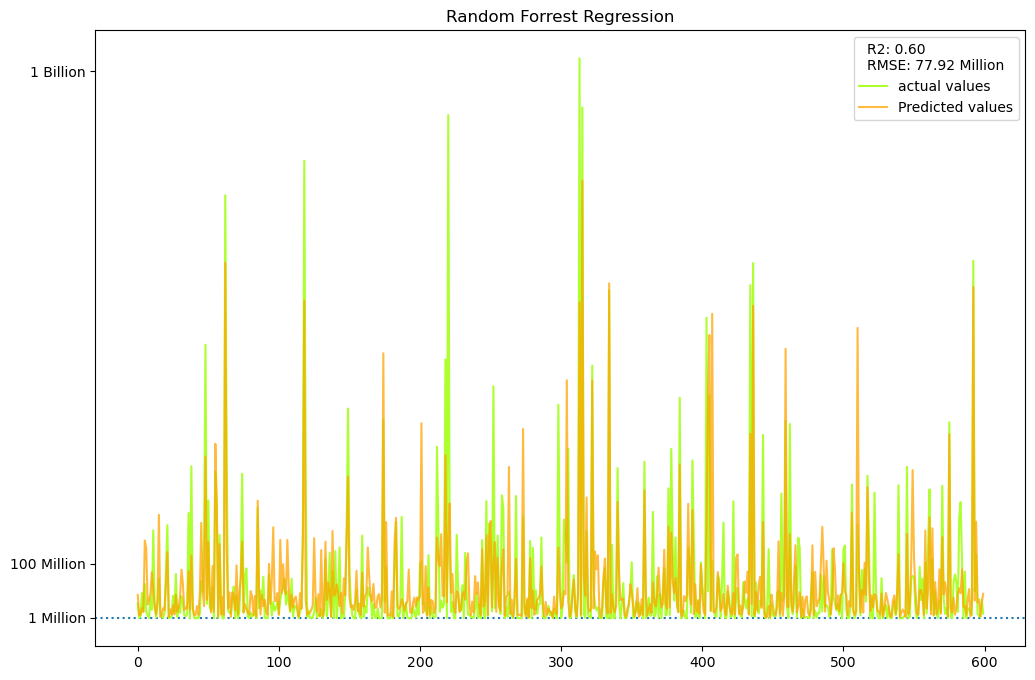

In [7]:
plt.figure(figsize=(12, 8))
plt.title("Random Forrest Regression")
plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])
# Draw line for 0 values
plt.axhline(y=0, linestyle='dotted')
# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

# plotting the graph for predictions
plt.plot([i for i in range(len(y_test))],y_predict, label="Predicted values", c='orange',alpha=0.75,zorder=10)



mse = metrics.mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_predict)
print( f"R2 : {r2} \nRMSE: {rmse}")
plt.legend(title=f"R2: {r2:.2f}\nRMSE: {(rmse/1000000):.2f} Million")
plt.show()

## Test Model over 100 train test splits

In [8]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split data
train_df = pd.read_csv('../Source/train.csv')
train_df = normalize(train_df)
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

r2_average = 0;
rmse_average = 0;
number_of_loops = 100

for j in range(0,number_of_loops):
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_loop = sc_X.fit_transform(X)
    y_loop = sc_y.fit_transform(pd.DataFrame(y))
    X_train, X_test, y_train, y_test = train_test_split(X_loop, y_loop, test_size=.10, random_state=j)
    
    RF_best = RandomForestRegressor(random_state=2,criterion='friedman_mse', max_depth=8, min_samples_split=5, min_weight_fraction_leaf=0.001)
    RF_best.fit(X_train, y_train.ravel())
    y_pred = RF_best.predict(X_test)    
    
    #  fitting the size of the plot
    #plt.figure(figsize=(12, 8))
    #plt.title(f"ADABoost\nRandom State {j}")
    #plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])


    y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred)) 
    y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 

    # Draw line for 0 values
    #plt.axhline(y=0, linestyle='dotted')

    # plotting the graph for the actual values
    #plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

    # plotting the graph for predictions
    #plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values", c='orange', alpha=0.75)#, s=5)

    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    r2_average += r2
    rmse_average += rmse
    print( f"R2: {r2} RMSE: {rmse/1000000}\n j = {j}")
    #plt.legend(title=f"r2_score:  {r2:.3f}\nRMSE:  {rmse/1000000:.2f} million")
    #plt.savefig(f"./Plots/ADA_Boost_{j}.png")
print(f"\n R2 average: {r2_average/number_of_loops}\n RMSE Average: {(rmse_average/number_of_loops)/1000000}")

#plt.show()


R2: 0.7452241958867556 RMSE: 75.58790938501753
 j = 0
R2: 0.5892379958279488 RMSE: 79.21804725749442
 j = 1
R2: 0.5154642905522951 RMSE: 79.31511780674343
 j = 2
R2: 0.6405483785567238 RMSE: 78.31848281332559
 j = 3
R2: 0.671584775181408 RMSE: 77.17156125077334
 j = 4
R2: 0.571659942765617 RMSE: 63.475663294512
 j = 5
R2: 0.7179697766284774 RMSE: 90.09797851518702
 j = 6
R2: 0.6749017858917644 RMSE: 85.58844248652638
 j = 7
R2: 0.7061647050036803 RMSE: 74.2112673322736
 j = 8
R2: 0.7394015247858199 RMSE: 60.58787718154654
 j = 9
R2: 0.7257747798949159 RMSE: 75.664226366771
 j = 10
R2: 0.6206072440854453 RMSE: 80.09937775188511
 j = 11
R2: 0.7669776549199967 RMSE: 57.061504128709565
 j = 12
R2: 0.3521770691064863 RMSE: 83.96322617584623
 j = 13
R2: 0.7271703390725434 RMSE: 80.59780779569311
 j = 14
R2: 0.6953111328167034 RMSE: 79.81930248189201
 j = 15
R2: 0.6991164236214639 RMSE: 90.49585256756976
 j = 16
R2: 0.711487833900976 RMSE: 79.90882491703113
 j = 17
R2: 0.6176338251477151 RMSE